# Visualising the collections on a map

In this notebook, we're going to use a secondary API to visualise the geographical extent of the collection on a map. 

The collection contains place names in the `production` field, which describes the time, place, and agents involved in the creation of the work. If we can turn those place names into coordinates, we can visualise the geographical extent of the collection on a map.

We'll use the API at <https://geocode.maps.co/> to handle the complicated geocoding for us.

In [2]:
import requests
import pandas as pd
import time
from tqdm.auto import tqdm

## 6.1 Geocoding individual place names

First, we need to define a function which will turn a place name into a pair of latitude and longitude values. We'll use the `requests` library to make a request to the geocoding API with our place name, and assume that the first result is the correct one. If the API returns a result, we'll return the latitude and longitude coordinates, otherwise we'll return a pair of `None` values.

In [3]:
def geocode_place(place):
    """Geocode a place name to lat/lon coordinates."""
    try:

        response = requests.get(
            "https://geocode.maps.co/search/",
            params={"q": place},
        ).json()

        lat = float(response[0]["lat"])
        lon = float(response[0]["lon"])

        # Add a delay to avoid hitting the API rate limit with multiple requests.
        # the rate limit is 2 requests per second, see https://geocode.maps.co/
        time.sleep(0.55)

        return (lat, lon)
    except (IndexError, requests.JSONDecodeError, ConnectionError):
        return (None, None)

In [4]:
geocode_place("London")

(51.5073219, -0.1276474)

That looks right to me! 

## 6.2 Geocoding lots of data

Let's download a bunch of works from the collection and store their IDs and place names in a pandas dataframe.

In [5]:
base_url = "https://api.wellcomecollection.org/catalogue/v2/"
n_works_to_fetch = 500

response = requests.get(
    base_url + "works",
    params={"pageSize": 100, "include": "production"},
).json()

works = response["results"]

while "nextPage" in response and len(works) < n_works_to_fetch:
    response = requests.get(response["nextPage"]).json()
    works.extend(response["results"])

The place names are stored in the `production` field, which is a list of `ProductionEvent` objects. Let's unpack the place name for the first productionEvent of each work, and store them in a dataframe.

In [6]:
df = pd.DataFrame({}, columns=["place"])


In [7]:
for work in works:
    if len(work["production"]) > 0:
        production = work["production"][0]
        if len(production["places"]) > 0:
            df.loc[work["id"]] = production["places"][0]["label"]

Now we can use our `geocode_place` function to turn our place names into pairs of latitudes and longitudes.

In [8]:
lats, lons = zip(*[geocode_place(place) for place in tqdm(df["place"].values)])

  0%|          | 0/341 [00:00<?, ?it/s]

In [10]:
df["lat"] = lats
df["lon"] = lons
df

,place,lat,lon
a222wwjt,London,51.507322,-0.127647
a2239muq,Leipzig,51.340632,12.374733
a223speg,London,51.507322,-0.127647
a22526q9,Florence,43.769871,11.255576
a2262ru9,[London],NaN,NaN
...,...,...,...
a2bat6my,London,51.507322,-0.127647
a2bb7tu8,London,51.507322,-0.127647
a2bchm2s,Edinburgh,55.953346,-3.188375
a2be4wwc,London,51.507322,-0.127647


Let's have a look at the most common place names in the collection:

In [11]:
df["place"].value_counts()

place
London                                85
No place, unknown, or undetermined    15
Edinburgh                             13
[London]                              13
Paris                                  9
                                      ..
[India],                               1
Stockholm                              1
[s.l.]                                 1
Baltimore                              1
Abidjan                                1
Name: count, Length: 156, dtype: int64

There are a lot of rows where the API has failed to find a matching place name, eg those `No place, unknown, or undetermined` values. Let's drop those rows from our dataframe.

In [12]:
df[df['place'] == 'No place, unknown, or undetermined']

,place,lat,lon
a22u9q35,"No place, unknown, or undetermined",NaN,NaN
a233s5ed,"No place, unknown, or undetermined",NaN,NaN
a23gbkux,"No place, unknown, or undetermined",NaN,NaN
a23tvmv4,"No place, unknown, or undetermined",NaN,NaN
a24ue2bn,"No place, unknown, or undetermined",NaN,NaN
a26sp2cg,"No place, unknown, or undetermined",NaN,NaN
a26su3tt,"No place, unknown, or undetermined",NaN,NaN
a26sxaxm,"No place, unknown, or undetermined",NaN,NaN
a27jegdb,"No place, unknown, or undetermined",NaN,NaN
a29agb3s,"No place, unknown, or undetermined",NaN,NaN


In [13]:
df = df.dropna()

In [14]:
len(df)

287

Let's produce a simple scatter plot of the latitude and longitude values we've found. We'll use the `alpha` parameter to make the points semi-transparent, so that we can see where there are tightly-packed clusters of points.

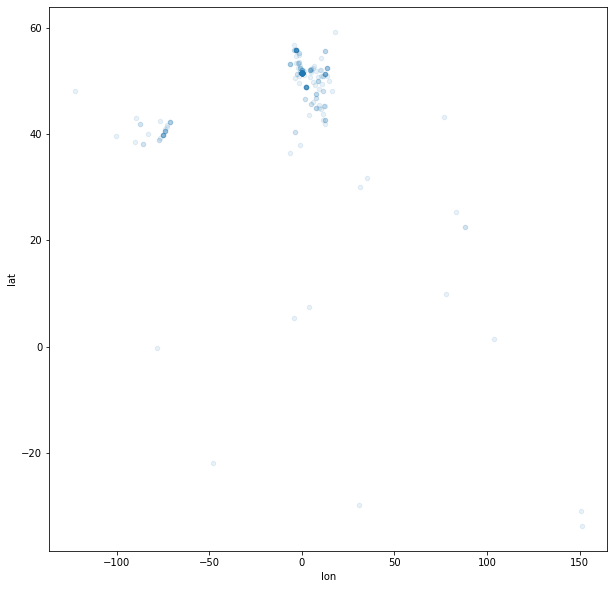

In [15]:
df.plot.scatter(x="lon", y="lat", alpha=0.1, figsize=(10, 10));

## 6.3 Using bounding boxes

As well as returning a latitude and longitude value, the geocoding API also returns a bounding box for each place name. We can use these bounding boxes to draw a rectangle around each point on our map, showing the areas where the catalogue records are precise (eg `Paris (Rue des Mathurins)`), or where they're more vague (eg `France`).

By plotting a semi-transparent box for each set of coordinates, The areas of the world where the boxes overlap will be darker, indicating that more works were produced in that region.

In [22]:
def geocode_place_bounding_box(place):
    """Geocode a place name to a bounding box."""

    try:
        response = requests.get(
            "https://geocode.maps.co/search/",
            params={
                "q": place,
            },
        ).json()

        box = [float(x) for x in response[0]["boundingbox"]]

        # Add a delay to avoid hitting the API rate limit with multiple requests.
        # rate limit is 2 requests per second, see https://geocode.maps.co/
        time.sleep(0.55)

        return box
    except (IndexError, requests.JSONDecodeError, ConnectionError):
        return (None, None, None, None)

In [23]:
lat_1, lat_2, lon_1, lon_2 = zip(
    *[geocode_place_bounding_box(place) for place in tqdm(df["place"].values)]
)

  0%|          | 0/287 [00:00<?, ?it/s]

In [26]:
df["lat_1"] = lat_1
df["lat_2"] = lat_2
df["lon_1"] = lon_1
df["lon_2"] = lon_2

df = df.dropna()

(-90.0, 90.0)

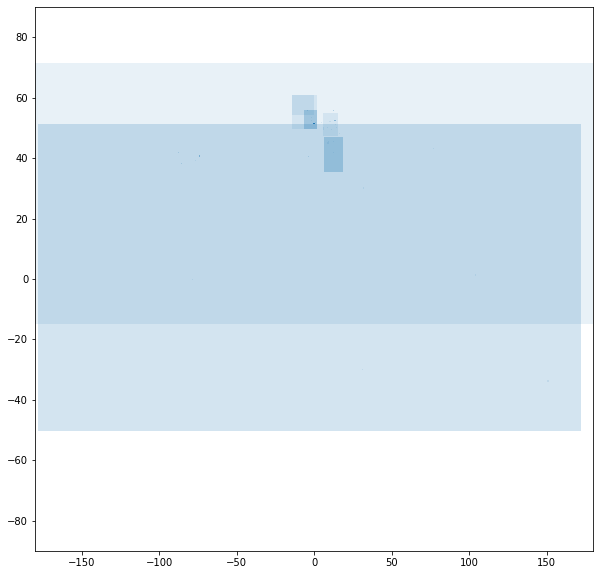

In [27]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 10))

for _, row in df.iterrows():
    ax.add_patch(
        plt.Rectangle(
            (row["lon_1"], row["lat_1"]), # bottom left corner
            row["lon_2"] - row["lon_1"], # width
            row["lat_2"] - row["lat_1"], # height
            alpha=0.1,
        )
    )

ax.set_xlim(-180, 180)
ax.set_ylim(-90, 90);

## Creating an interactive map

We can use a library called `folium` to visualise the coordinates on an interactive map.

Let's make sure that we've got the latest version of `folium` installed:

In [42]:
!pip install -U --quiet folium selenium

N.B. You won't be able to see this if you're reading the markdown version of this notebook, or viewing it on GitHub. You'll need to run the notebook yourself to see the interactive plot.

In [40]:
import folium

m = folium.Map()

for _, row in df.iterrows():
    folium.CircleMarker(
        location=[row["lat"], row["lon"]],
        radius=1,
        fill = True,
        color='red',
        fill_color='red'
    ).add_to(m)

m

## Exercises

1. Look for more patterns in the data which indicate that the geocoding might be incorrect - can you clean up the data to make the map more accurate?
2. Filter the works using a set of lat/lon boundaries, returning everything from a particular region, eg Scotland. Comparing those works to the rest of the data, can you find any similarities or differences? Do any interesting narratives emerge?